In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix
%matplotlib inline

DDoS = pd.read_csv('/content/dataset_sdn.csv')
DDoS.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [2]:
DDoS.Protocol.unique()
DDoS['Protocol'] = DDoS['Protocol'].replace('TCP', '0')
DDoS['Protocol'] = DDoS['Protocol'].replace('UDP', '1')
DDoS['Protocol'] = DDoS['Protocol'].replace('ICMP', '2')
DDoS.Protocol.unique()

array(['1', '0', '2'], dtype=object)

In [3]:
DDoS["rx_kbps"] = DDoS["rx_kbps"].fillna(DDoS["rx_kbps"].mean())

In [4]:
DDoS["tot_kbps"] = DDoS["tot_kbps"].fillna(DDoS["tot_kbps"].mean())

In [5]:
from sklearn.model_selection import train_test_split
features =DDoS[['dt', 'switch', 'pktcount', 'bytecount', 'dur', 'tot_dur',
       'flows', 'packetins', 'pktperflow', 'byteperflow', 'pktrate',
       'Pairflow','Protocol' ,'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps',
       'tot_kbps']]
labels = DDoS['label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [6]:
# Feature scaling (or standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(83476, 19)
(83476,)
(20869, 19)
(20869,)


In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Input
from keras.layers import Convolution1D, Dense, Dropout, MaxPooling1D, LSTM
from keras.layers import Dense, Dropout, Activation, Lambda, Flatten
convnet=keras.models.Sequential()
convnet.add(keras.layers.Convolution1D(32,3,activation="relu",input_shape=(19,1)))
convnet.add(keras.layers.Convolution1D(64,3,activation="relu"))
convnet.add(keras.layers.BatchNormalization())
convnet.add(keras.layers.MaxPooling1D(2,2))
convnet.add(keras.layers.Dropout(0.25))
convnet.add(keras.layers.Flatten())
convnet.add(keras.layers.Dense(128,activation="relu"))
convnet.add(keras.layers.Dropout(0.25))
convnet.add(keras.layers.Dense(2,activation="softmax"))
convnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 17, 32)            128       
                                                                 
 conv1d_3 (Conv1D)           (None, 15, 64)            6208      
                                                                 
 batch_normalization_1 (Batc  (None, 15, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 7, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 448)              

In [16]:

#compile
convnet.compile(loss='sparse_categorical_crossentropy' , optimizer='adam' , metrics=['accuracy'])

#fit
history=convnet.fit(x=X_train, y=y_train, validation_split=0.1, epochs=20, batch_size=16)

testloss,testaccuracy=convnet.evaluate(X_test,y_test)
print("Test Loss =",testloss)
print("Test Accuracy =",testaccuracy)

Epoch 1/20
4696/4696 [==============================] - 24s 5ms/step - loss: 0.0224 - accuracy: 0.9919 - val_loss: 0.0117 - val_accuracy: 0.9965
Epoch 2/20
4696/4696 [==============================] - 24s 5ms/step - loss: 0.0191 - accuracy: 0.9930 - val_loss: 0.0062 - val_accuracy: 0.9981
Epoch 3/20
4696/4696 [==============================] - 22s 5ms/step - loss: 0.0199 - accuracy: 0.9930 - val_loss: 0.0166 - val_accuracy: 0.9941
Epoch 4/20
4696/4696 [==============================] - 24s 5ms/step - loss: 0.0169 - accuracy: 0.9939 - val_loss: 0.0077 - val_accuracy: 0.9978
Epoch 5/20
4696/4696 [==============================] - 23s 5ms/step - loss: 0.0161 - accuracy: 0.9940 - val_loss: 0.0050 - val_accuracy: 0.9977
Epoch 6/20
4696/4696 [==============================] - 23s 5ms/step - loss: 0.0159 - accuracy: 0.9943 - val_loss: 0.0056 - val_accuracy: 0.9978
Epoch 7/20
4696/4696 [==============================] - 24s 5ms/step - loss: 0.0144 - accuracy: 0.9950 - val_loss: 0.0136 - val_ac

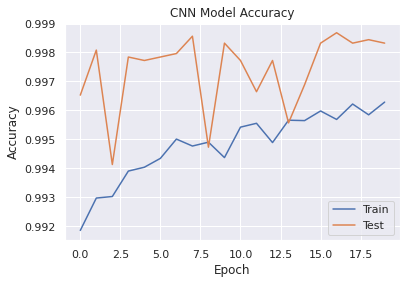

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('CNN Model Accuracy.png')
plt.show()

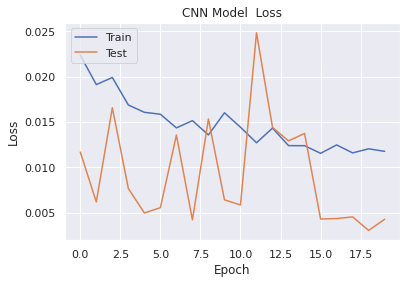

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('CNN Model Loss.png')
plt.show()

In [21]:
predict = convnet.predict(X_test, verbose=1)

653/653 [==============================] - 3s 5ms/step


In [22]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1

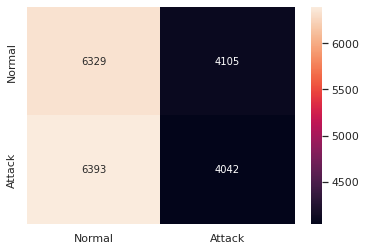

In [23]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Normal","Attack"],columns = ["Normal","Attack"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [24]:
scores = convnet.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (convnet.metrics_names[1], scores[1]*100))

accuracy: 99.88%
